# Create flying node graph
This Notebook will create the graph we will use for flying our drone. We do it once so we don't have to do it everytime we load the simulator.

## Imports

In [1]:
import networkx as nx
nx.__version__

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from planning_utils import heuristic, create_grid
import time

%matplotlib inline

## Load Data

In [2]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Visualize map grid

In [3]:
print('start')
drone_altitude = 5
safety_distance = 3
grid, points, north_offset, east_offset = create_grid(data, drone_altitude, safety_distance)
print('done')

start
done


start


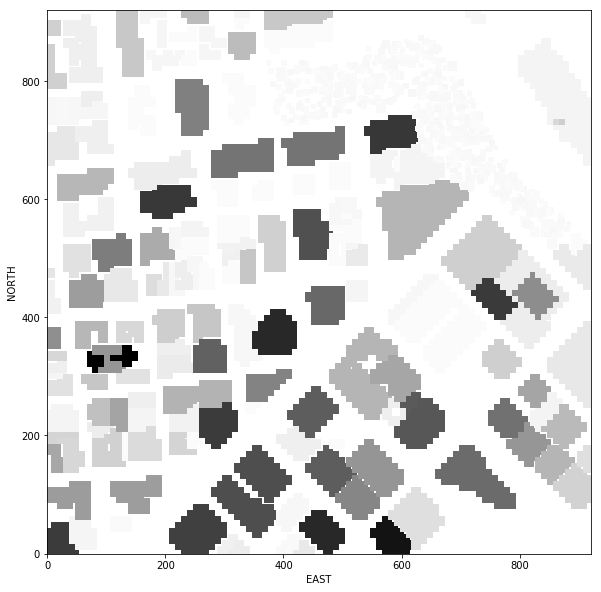

done


In [4]:
import matplotlib.pyplot as plt
print('start')
# Plot it up!
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, origin='lower', cmap='Greys')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
print('done')

## Voronoi graph method

In [6]:
print('Creating Voronoi')
# Create a voronoi graph based on location of obstacle centres (2D no height)
t0 = time.time()
np_points = np.array(points)
voronoi_graph = Voronoi(np_points[:,:-1])
print('Voronoi Graph with {0} nodes'.format(len(voronoi_graph.vertices)))
print('Voronoi Graph took {0} seconds to build'.format(time.time()-t0))

Creating Voronoi
Voronoi Graph with 5858 nodes
Voronoi Graph took 0.05158495903015137 seconds to build


In [7]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree

def create_graph_from_voronoi(voronoi_graph):
    g = nx.Graph()
    nodes = tuple(map(tuple, voronoi_graph.vertices))
    tree = KDTree(nodes)
    # Check each edge from graph.ridge_vertices for collision
    for v in voronoi_graph.ridge_vertices:
        p1 = voronoi_graph.vertices[v[0]]
        p2 = voronoi_graph.vertices[v[1]]
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit = False

        for c in cells:
            # First check if we're off the map
            if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                hit = True
                break
            # Next check if we're in collision
            if grid[c[0], c[1]] > drone_altitude:
                hit = True
                break

        # If the edge does not hit on obstacle
        # add it to the list
        if not hit:
            dist = LA.norm(np.array(p2) - np.array(p1))
            g.add_edge((p1[0], p1[1], drone_altitude), (p2[0], p2[1], drone_altitude), weight=dist)

    return g, tree

print('Creating NxGraph')
t0 = time.time()
g, t = create_graph_from_voronoi(voronoi_graph)
print('Graph took {0} seconds to build'.format(time.time()-t0))

Creating NxGraph
Graph took 12.409908294677734 seconds to build


In [8]:
print('Grid dimensions: ', grid.shape)
print('Original nodes: ', len(voronoi_graph.vertices))
print('Graph nodes: %5d' % len(g.nodes))
print('Graph edges: %5d' % len(g.edges))

Grid dimensions:  (921, 921)
Original nodes:  5858
Graph nodes:  1965
Graph edges:  1895


## Save to pickle

In [9]:
import pickle

# Dump the graph with Pickle
pkl_filename = 'graph.voronoi.p'

try:
    with open(pkl_filename, 'wb+') as pfile:
        print('Saving to pickle file ', pkl_filename)
        pickle.dump(
        {
            'graph': g,
            'kdtree': t,
        },
        pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to ', pkl_filename, ':', e)

print('done')

Saving to pickle file  graph.voronoi.p
done


## Load from pickle

In [10]:
import pickle

pkl_filename = 'graph.voronoi.p'
with open(pkl_filename, "rb") as pfile:
    print('Reading pickle')
    dist_pickle = pickle.load(pfile)

    g = dist_pickle['graph']
    t = dist_pickle['kdtree']

print('done')

Reading pickle
done


## Visualize graph

start


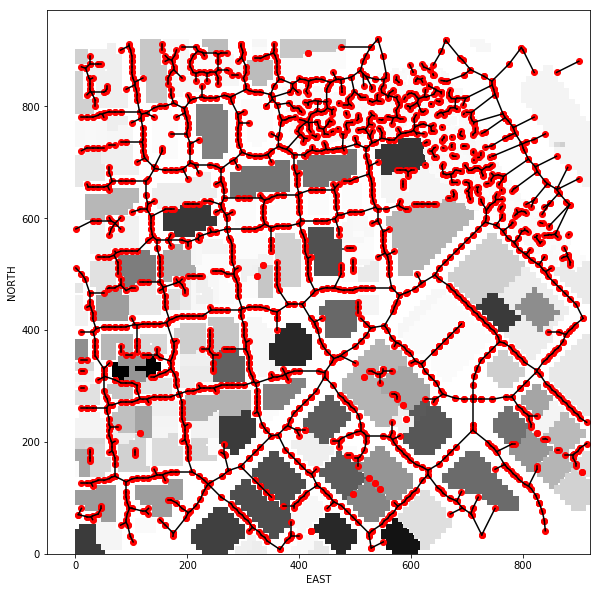

done


In [11]:
import matplotlib.pyplot as plt
print('start')
# Plot it up!
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, origin='lower', cmap='Greys') 

# Draw edges
# and connected nodes in red
for (n1, n2) in g.edges:
    plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'black', alpha=1)
    plt.scatter(n1[1], n1[0], c='red')
    plt.scatter(n2[1], n2[0], c='red')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
print('done')

## A*

In [36]:
from planning_utils import a_star_graph

rnd = np.random.randint(len(g.nodes))
start = list(g.nodes)[rnd]
print('Start: ', rnd)
rnd = np.random.randint(len(g.nodes))
print('Goal: ', rnd)
goal = list(g.nodes)[rnd]

path, cost = a_star_graph(g, heuristic, start, goal)
print(len(path), path)

path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

Start:  853
Goal:  8
Found a path.
53 [(258.7611663999719, 498.7684424000187, 5), (246.76114539999378, 506.76845640000414, 5), (230.76111499998, 510.76846, 5), (219.0944511111126, 510.76846, 5), (215.76108800007643, 515.7685079999173, 5), (210.761115, 520.7684800000001, 5), (210.761115, 550.7685250000201, 5), (208.26112312499765, 563.2684943749992, 5), (204.0944694444176, 567.435152222233, 5), (199.33252857142858, 569.3399285714286, 5), (187.90395714285714, 577.9113571428571, 5), (183.61824285714286, 583.6256428571429, 5), (177.90395714285714, 587.9113571428571, 5), (173.61824285714286, 593.6256428571429, 5), (167.90395714285714, 597.9113571428571, 5), (159.33247040761663, 609.3400061231779, 5), (154.76104999990002, 620.7685, 5), (148.76106000000001, 630.76845, 5), (160.76111875003906, 650.7684812499609, 5), (170.76100624933596, 660.7683437496016, 5), (170.76100625066408, 660.7683437503985, 5), (180.76111874996093, 670.768481250039, 5), (180.761174999375, 670.768574999375, 5), (190.761